<header>
   <p  style='font-size:36px;font-family:Arial; color:#F0F0F0; background-color: #00233c; padding-left: 20pt; padding-top: 20pt;padding-bottom: 10pt; padding-right: 20pt;'>
       Optimize Customer Segmentation using ClearScape Analytic Functions and Open-Source LLMs
  <br>
       <img id="teradata-logo" src="../../images/TeradataLogo.png" alt="Teradata" style="width: 125px; height: auto; margin-top: 20pt;">
    </p>
</header>
<hr>

<br>

<b style = 'font-size:24px;font-family:Arial;color:#00233C'>Leverage highly-scalable native processing functions to create ideal customer segments using word embeddings and clustering algorithms</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Vector embedding</b> is a numerical representation of data that captures semantic relationships and similarities, making it possible to perform mathematical operations and comparisons on the data for various tasks like text analysis and recommendation systems.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>K-means clustering</b> is one of the most popular <b>unsupervised</b> machine learning algorithms.  Essentially, the algorithm seeks to group similar data points together by minimizing the average ("means" in K-means) distance for all data points from each cluster's center (centroid).</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Using <b>Teradata Vantage</b> and <b>ClearScape Analytics</b>, we can combine these advanced AI and ML techniques to <b>rapidly</b> find the ideal number of customer segments based on the semantic meaning of their comments history.  This segmentation can be used on its own for marketing and other tasts, or used in further predictive analytics use cases.</p>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
            <ol style = 'font-size:16px;font-family:Arial;color:#00233C'>
                <li>Create a Vector Embedding table using open-source LLMs applied at scale in the database</li>
                <br>
                <li>Rapidly iterate over multiple K-means models, evaluating each</li>
                <br>
                <li>Visualize the experimental results to indicate the best cluster</li>
            </ol>
        </td>
        <td><img src = 'images/comparative_superlative_small.jpg' width = '250'></td>
        <td><img src = 'images/K-means_convergence.gif' width = '250'></td>
    </tr>
</table>

<hr>

In [ ]:
from teradataml import *
from teradatasqlalchemy.types import VARCHAR
import pandas as pd
import csv
import os

from IPython.display import display as ipydisplay
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

display.suppress_vantage_runtime_warnings = True

dims = [f"v{i}" for i in range(1, 51)]

# load vars json
with open('../../vars.json', 'r') as f:
    session_vars = json.load(f)

# Create the SQLAlchemy Context
host = session_vars['environment']['host']
username = session_vars['hierarchy']['users']['business_users'][1]['username']
password = session_vars['hierarchy']['users']['business_users'][1]['password']

eng = create_context(host=host, username=username, password=password)

# confirm connection
print(eng)

<hr>
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Step 1 - Data Preparation using an LLM to create a Vector Table</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Here, we will inspect the original data set, and use native vector embedding functions to generate features</p>

<ol style = 'font-size:16px;font-family:Arialcolor:#00233C'>
    <li>Inspect the rows of the Customer Comments table</li>
    <li>Inspect the GloVe Model table</li>
    <li>Use TD_WordEmbeddings function to create the vector table</li>
    </ol>
    

<hr>
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>1.1 - Inspect the Data</b>

<p style = 'font-size:16px;font-family:Arialcolor:#00233C'>Simple DataFrame methods to show the data</p>

In [9]:
tdf_comments = DataFrame('"demo_ofs"."web_comment"')

ipydisplay(tdf_comments.head(2))

comment_id,customer_id,comment_text,comment_summary
1,1080,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",None
0,767,Absolutely wonderful - silky and sexy and comfortable,None


<hr>
<b style = 'font-size:18px;font-family:Arial;color:#00233'>1.2 - Model table</b>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>We format the model table as in the documentation: a column for the token, and a column for each dimension of the vector space. This example uses the GloVe 50-dimensional pre-trained embeddings. We filter out non-ASCII characters to comply with the function's requirements.</p>

In [10]:
tdf_glove_50d = DataFrame('"demo_ofs"."glove_6B_50d"')
ipydisplay(tdf_glove_50d.sample(2))

doc_id,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,sampleid
elvey,-0.52216,0.52649,0.57083,-2.4293,-2.1924,0.97767,1.2428,0.48399,-0.022573,1.2851,-0.038686,0.45641,-1.2275,0.12887,-0.53458,-0.36714,1.3803,0.03778,-0.64607,-0.75895,1.2153,1.1781,0.031438,-0.98033,-0.82746,0.77427,-0.54949,0.43771,0.070184,1.6329,-1.3426,-0.39163,1.0126,-1.1617,-0.59199,0.93161,-0.25696,-0.85203,-0.17227,0.031365,0.99798,1.3736,0.23865,-1.3173,-0.80487,-0.87183,-0.095018,-0.90291,-1.5793,-0.48346,1
diabolical,0.91927,-0.80414,-0.40448,-0.04351,0.48769,0.41372,0.79325,-0.3884,-0.36378,1.1139,-0.7066,0.64198,-0.37332,0.22406,-0.13299,-0.45853,0.63223,0.094305,0.086931,0.64328,-0.15797,-0.039146,-0.31624,-0.37992,0.20076,-0.18116,-0.58734,0.031684,0.82656,-0.63389,-0.10097,-0.48076,-0.26688,0.12883,0.0053213,0.45039,-0.43933,-0.12246,-0.39044,-0.62565,-0.17374,-0.4669,0.12688,0.44954,0.17376,-0.55525,0.67476,0.20597,0.83963,0.024849,1


<hr>
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>1.3 - Embeddings</b>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>TD_WordEmbeddings can perform four operations: token-embedding, doc-embedding, token2token-similarity, and doc2doc-similarity. This notebook shows the first two.  We will use doc-embedding as the basis for our Segmentation.</p>

In [11]:
WordEmbeddings(
    data=tdf_comments.head(1),
    model=DataFrame('"demo_ofs"."glove_6B_50d"'),
    id_column="comment_id",
    model_text_column="doc_id",
    model_vector_columns=dims,
    primary_column="comment_text",
    operation="token-embedding"
    ).result

comment_id,TD_Token,TD_TokenCount,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50
0,comfortable,1,-0.21425,0.068749,-0.081586,-0.27136,0.99847,-0.33449,-0.49247,0.2351,-0.62932,0.12907,-0.45034,-0.677,-0.17766,0.29644,-0.11985,0.6188,0.22896,-0.2552,0.46635,-1.182,-0.74713,0.92787,-0.47856,0.45844,0.62039,-0.60133,0.11921,0.69953,0.94607,0.035007,2.4995,1.1263,0.29125,0.12052,0.1805,-0.098443,0.18226,1.6886,-0.31017,-1.0232,0.090747,-0.27259,0.35584,1.1213,-0.37477,0.39062,-0.43588,-0.5285,0.35525,0.70676
0,absolutely,1,0.36582,-0.43975,-0.35016,0.096443,0.99511,-0.16116,0.50959,0.29773,-0.099699,0.60155,-0.42716,0.31336,-0.77696,-0.4178,1.0255,0.32461,1.1111,0.40362,0.25327,-0.47051,-0.67384,0.95534,0.1788,-0.16676,1.1174,-1.3922,-1.1538,0.94848,1.3498,-0.33948,2.1633,-0.085271,-0.2314,-0.64229,-0.76036,-0.33164,0.75103,0.11934,-0.39501,-0.38973,-0.00025582,-0.47844,0.18316,0.25634,-0.28993,0.32992,-1.1011,0.8687,0.68687,0.96048
0,silky,1,-0.26831,-0.13454,-1.8179,0.36332,0.34287,0.84508,0.20526,-0.42332,0.46929,0.17958,0.27243,0.37917,0.56063,0.20263,-1.2165,-0.43508,-0.02032,0.057007,-0.093196,-1.3579,-1.5306,0.69662,0.62579,-0.53322,-0.0063314,0.56397,-0.049352,1.4671,0.26434,-0.51571,0.79537,-0.052818,0.26291,0.85787,0.16713,0.028354,-0.89476,0.52989,-0.42234,-0.85901,0.60424,0.30946,-0.16478,0.26658,0.54582,-0.48803,0.67927,-0.38916,-0.46679,0.2561
0,wonderful,1,0.23533,0.9132,-1.2008,0.0065595,1.2843,-0.10495,-0.46928,-0.16064,-0.0023046,0.88219,-0.58227,0.49887,0.28537,0.021317,0.70205,-0.24932,0.63965,0.68058,-0.096489,-0.69284,-0.14633,1.1343,-0.15865,-0.034477,1.4644,-0.46223,-1.3821,0.45211,0.9922,-0.55959,2.0021,0.54034,-0.080539,-0.021476,0.026856,0.42905,-0.1189,0.69764,-0.029882,-0.58077,0.20491,0.095888,-0.39682,-0.18709,0.21904,0.57694,0.066142,-0.16162,-0.02467,0.84626
0,sexy,1,-0.18216,0.097173,-0.91049,-0.29208,0.2616,0.37649,0.34825,-0.92324,-0.63641,1.0532,-0.15582,0.22872,-0.32468,0.85363,0.29449,-0.015068,-0.18929,0.67549,0.44233,-0.63204,-0.70315,1.3187,0.33291,0.95469,-0.039136,-0.68223,-1.5678,1.1764,0.84656,-0.69379,1.1227,0.36665,0.26621,0.41286,0.17698,0.16484,-0.24153,0.19944,-0.95562,-1.4336,0.2826,0.33355,0.4972,-0.24011,0.83822,-0.83901,0.49013,-1.1877,0.4906,1.2877
0,and,2,0.26818,0.14346,-0.27877,0.016257,0.11384,0.69923,-0.51332,-0.47368,-0.33075,-0.13834,0.2702,0.30938,-0.45012,-0.4127,-0.09932,0.038085,0.029749,0.10076,-0.25058,-0.51818,0.34558,0.44922,0.48791,-0.080866,-0.10121,-1.3777,-0.10866,-0.23201,0.012839,-0.46508,3.8463,0.31362,0.13643,-0.52244,0.3302,0.33707,-0.35601,0.32431,0.12041,0.3512,-0.069043,0.36885,0.25168,-0.24517,0.25381,0.1367,-0.31178,-0.6321,-0.25028,-0.38097


In [12]:
tdf_embeddings = WordEmbeddings(
                data=tdf_comments.iloc[:1000],
                model=DataFrame('"demo_ofs"."glove_6B_50d"'),
                id_column="comment_id",
                model_text_column="doc_id",
                model_vector_columns=dims,
                primary_column="comment_text",
                operation="doc-embedding",
                accumulate=['comment_text', 'customer_id']
                ).result
copy_to_sql(tdf_embeddings, table_name = 'comments_embedded', if_exists = 'replace')
tdf_embeddings = DataFrame('comments_embedded')
tdf_embeddings.sample(2)

comment_id,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,comment_text,customer_id,sampleid
540,0.179100415,0.14481733,-0.38424028,-0.20812360000000002,0.4446211000000001,0.15159689999999998,-0.265802555,-0.20655744999999995,-0.34360580999999996,0.005594050000000015,0.030036299999999995,0.30421265000000003,-0.20005144999999996,0.022591899999999998,0.35642925,0.31091395000000005,0.11216398499999998,0.08257563500000002,-0.11520306500000004,-0.7041885,-0.36540445000000005,0.26067609999999997,0.24184669999999997,0.036543599999999996,0.2230172,-1.5115435,-0.604639,0.46253105000000005,0.48456245000000003,-0.25841729999999996,2.9949593,0.1961928,-0.10516624999999999,-0.35526620000000003,0.10432194999999997,0.010876650000000005,0.019237650000000002,0.39820954999999997,-0.30162775000000003,-0.41008870000000003,-0.10360170000000005,0.19355471,0.170366,0.210085798,0.027658349999999998,-0.029361000000000005,-0.10428975,-0.16127625,0.014560199999999995,0.34197120000000003,"This dress is comfortable as well as flattering, which does not happen very often! looks good with navy tights too!",1078,1
325,0.20798557600000003,0.236018676,-0.16489224000000008,-0.06466124000000004,0.3772886693333333,0.18616984373333334,-0.3124633973333332,-0.2984091893333333,-0.16487288506666664,-0.0006165933333333203,-0.013287453333333336,0.10445601199999997,-0.30313744000000004,-0.050605133333333316,0.29784698666666665,0.19123886666666667,0.1314108213333334,0.07280697333333333,-0.32716927200000007,-0.4683610173333334,-0.1299777693333333,0.1039908,0.22573743999999996,0.054621188,0.18545276000000002,-1.4016469333333332,-0.5589876533333334,0.33836749866666666,0.28726649333333326,-0.3165685466666665,3.162207333333333,0.08735994666666666,-0.04376804133333335,-0.19323024533333333,0.0770576650666667,0.020456210666666662,0.09786208399999999,0.1465563226666667,-0.07106233853333334,-0.2020797066666667,-0.06998775999999991,0.11967983466666669,-0.06597401466666666,0.1691328810666667,-0.05347390666666667,0.07937717599999998,-0.030985583999999986,-0.17462299999999994,0.016477646666666665,-0.01287807600000001,"Like another reviewer mentioned, this shirt is way too short. i'm only 5'2"" (xs) and there is no way this top would tuck in like on the model. also, the quality isn't great as it's very thin and there are strings hanging from some of the seams in the front. it's a shame b/c the print is really pretty and there is this cute little bicycle charm on the tag which makes it feel more unique. sadly, it's going back!",844,1


<hr>
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Step 2 - Find the Ideal K-means Model</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>As discussed above, the K-means algorithm takes a number of clusters "k", chooses a random starting point for each centroid, and iterates until a hard limit or an optimium value is reached.</p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'><b>Other Function Parameters Include (but are not limited to)</b></p>
<ul style = 'font-size:16px;font-family:Arial;color:#00233C'>
    <li>Input dataframe</li>
    <li>StopThreshold - The algorithm converges if the distance between the centroids from the previous iteration and the current iteration is less than the specified value.</li>
    <li>MaxIterNum</li>Specify the maximum number of iterations for the K-means algorithm. The algorithm stops after performing the specified number of iterations even if the convergence criterion is not met.
    </ul>
    
<hr>
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>2.1 - Example Model - 4-cluster test</b>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>The example below uses an arbitrary number of clusters to create the first model.  Note the output metadata provides information such as the number of iterations, converged or not, etc.</p>

In [13]:
KMeans(data = tdf_embeddings, 
        id_column = 'comment_id', 
        target_columns = dims, 
        num_clusters = 4, 
        iter_max = 100, 
        threshold=0.0295).result.to_pandas()[['td_withinss_kmeans', 'td_modelinfo_kmeans']].fillna('').sort_index()

,td_withinss_kmeans,td_modelinfo_kmeans
td_clusterid_kmeans,,
0.0,126.139759,
1.0,99.172996,
2.0,90.779354,
3.0,0.0,
NaN,,Number of Iterations : 6
NaN,,Total_WithinSS : 3.16092109338891E+02
NaN,,Between_SS : 6.39349389692738E+02
NaN,,Method for InitialCentroids : Random
NaN,,Number of Clusters : 4


<hr>
<b style = 'font-size:18px;font-family:Arial;color:#00233C'>2.2 - Finding an Ideal value for K</b>

<table style = 'width:100%;table-layout:fixed;'>
    <tr>
        <td style = 'vertical-align:top' width = '50%'>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>Typically, data scientists will build the model using various values for "k", and plot the "WCSS" (Within Cluster Sum-of-Squares) value on a series of each value chosen for k.  The "elbow" point (where the slope changes) is usually a good value for k.  <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Model-Training-Functions/TD_KMeans'>KMeans</a> function will return this value as "TotalWithinSS : ###" as a row in the "td_modelinfo_kmeans" column.</p>
<br>
<p style = 'font-size:16px;font-family:Arial;color:#00233C'>In the below example, we will iterate over this function using values from 2 to 8 for "k".  Due to the highly-scalable nature of the native training function, we can perform this analysis incredibly rapidly.</p>
        </td>
        <td><img src = 'images/WCSS_elbow.png' width = '300'></td>
    </tr>
    </table>

In [14]:
a = []
for k in range(2,9):
    kmeans_model = KMeans(data = tdf_embeddings, 
                        id_column = 'comment_id', 
                        target_columns = dims, 
                        num_clusters = k, 
                        iter_max = 100, 
                        threshold=0.0295)
    wss = kmeans_model.result.to_pandas()[['td_withinss_kmeans']].sum()[0]
    a.append([k, wss])
    print(f'{str(k)} clusters, WCSS = {str(wss)}')

df = pd.DataFrame(a, columns = ['k', 'WCSS']).set_index('k')

2 clusters, WCSS = 391.6025566020908
3 clusters, WCSS = 337.738338964944
4 clusters, WCSS = 315.9119690619027
5 clusters, WCSS = 304.27735764520503
6 clusters, WCSS = 295.6538300749221
7 clusters, WCSS = 288.34669149368824
8 clusters, WCSS = 281.3299231232511


<hr>
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Step 3 - Find the ideal number of Customer Segments</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>A simple plot will show the "elbow" point indicating an ideal number of clusters or segments.</p>

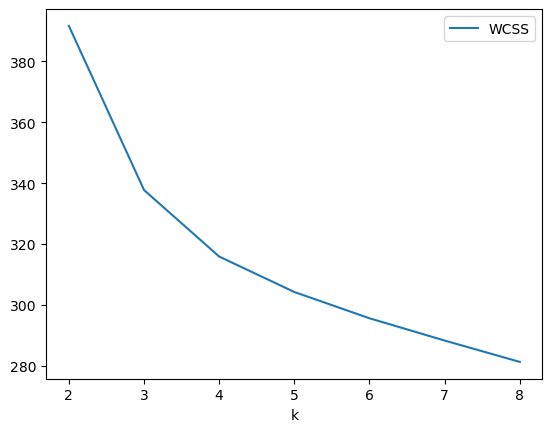

In [15]:
df.plot();

<hr>
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Conclusion</b></p>

<p style = 'font-size:16px;font-family:Arial;color:#00233C'>From our simple demonstration above, we can see how data practitioners can rapidly derive powerful and unique predictive features by combining the latest AI with traditional Machine Learning <b>at scale</b>.  Furthermore, we can easily operationalize this process by combining this vector embedding and segmentation into traditional Customer 360, analytics, or additional predicitve modeling tasks - all on the same platform.</p>

<hr>
<p style = 'font-size:20px;font-family:Arial;color:#00233C'><b>Cleanup</b></p>

In [ ]:
db_drop_table('comments_embedded')
remove_context()